In [6]:
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def get_session():
    """Create a session that dynamically allocates memory."""
    # See: https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


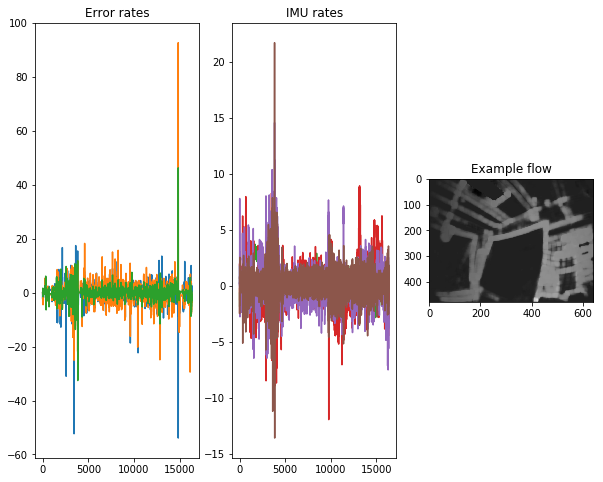

In [7]:
# Import data without time stamps
y_data = (np.genfromtxt('errors.csv', delimiter=',')[:,1:4]).astype(np.float32)
imu_data = (np.genfromtxt('rates.csv', delimiter=',')[:,1:7]).astype(np.float32)
imu_data = imu_data - imu_data.mean(axis=0)
flows_data = np.load('/media/Big_Data/stefantj/flows1.npy') # note: this only loads 1k flows, the whole flow file is huge!

plt.subplot(1,3,1)
plt.title('Error rates')
plt.plot(y_data)
plt.subplot(1,3,2)
plt.title('IMU rates')
plt.plot(imu_data)
plt.subplot(1,3,3)
plt.title('Example flow')
plt.imshow(flows_data[500,:,:,1])

# sample batch_size subsequences of length sequence_length, and return the label at the end of the sequence
def sample_minibatch(sequence_length, batch_size, iseq=None):
    x_imu_batch = np.zeros((batch_size, sequence_length, imu_data.shape[1]))
    x_img_batch = np.zeros((batch_size, flows_data.shape[1], flows_data.shape[2], flows_data.shape[3]))
    y_batch = np.zeros((batch_size, y_data.shape[1]))
    
    for k in range(batch_size):
        if(iseq is None):
            # randomly sample endpoint:
            i_stop = np.random.randint(sequence_length, flows_data.shape[0]) 
        else:
            i_stop = iseq - (batch_size-1-k)
        x_imu_batch[k, :, :] = imu_data[i_stop-sequence_length:i_stop,:]
        y_batch[k,:] = y_data[sequence_length,:]
        x_img_batch[k,:,:,:] = flows_data[i_stop,:,:,:]
    return x_imu_batch, x_img_batch, y_batch

def calc_rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [8]:
# Definition of network:

OUTPUT_DIM = 3
# fire module
# [inp, sp]     Size of first convolution
# [e11p, e33p]  Size of subsequent convolutions
def fire_module(x,inp,sp,e11p,e33p):
    with tf.variable_scope("fire"):
        with tf.variable_scope("squeeze"):
            W = tf.get_variable("weights",shape=[1,1,inp,sp])
            b = tf.get_variable("bias",shape=[sp])
            s = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")+b
            s = tf.nn.relu(s)
        with tf.variable_scope("e11"):
            W = tf.get_variable("weights",shape=[1,1,sp,e11p])
            b = tf.get_variable("bias",shape=[e11p])
            e11 = tf.nn.conv2d(s,W,[1,1,1,1],"VALID")+b
            e11 = tf.nn.relu(e11)
        with tf.variable_scope("e33"):
            W = tf.get_variable("weights",shape=[3,3,sp,e33p])
            b = tf.get_variable("bias",shape=[e33p])
            e33 = tf.nn.conv2d(s,W,[1,1,1,1],"SAME")+b
            e33 = tf.nn.relu(e33)
        return tf.concat([e11,e33],3)
    
class tangoNet(object):
    # For loading features from saved file or constructing new graph
    def extract_features(self, input=None, reuse=True):
        if input is None:
            input = self.image  # will need to split this into input1, input2
        x = input
        layers = []
        with tf.variable_scope('features', reuse=reuse):
            with tf.variable_scope('cnn_0'):
                W = tf.get_variable("weights", shape=[3,3,3,64])
                b = tf.get_variable("bias",shape=[64])
                x = tf.nn.conv2d(x, W, [1,2,2,1],"Valid")
                x = tf.nn.bias_add(x,b)
                layers.append(x)
            with tf.variable_scope('cnn_1'):
                x = tf.nn.relu(x)
                layers.append(x)
            with tf.variable_scope('cnn_2'):
                x = tf.nn.max_pool(x, [1,3,3,1],strides=[1,2,2,1],padding='Valid')
                layers.append(x)
            with tf.variable_scope('cnn_3'):
                x = fire_module(x, 64,16,64,64)
                layers.append(x)
            with tf.variable_scope('cnn_4'):
                x = fire_module(x, 128,16,64,64)
                layers.append(x)
            with tf.variable_scope('rnn_0'):
                W = tf.get_variable("weights", shape=[1,1,1,1])
                b = tf.get_variable("bias", shape=[1])
                

    def __init__(self, save_path=None, sess=None):
        self.image = tf.placeholder('float',shape=[None,None,None,2],name='input_image')
        self.imu   = tf.placeholder('float',shape=[None,6],name='input_imu_seq')
        self.errs  = tf.placeholder('float',shape=[None,3],name='output_error')
        self.layers = []
        x = self.image
        self.layers = self.extract_features(x, reuse=False)
        self.features = self.layers[-1]
        with tf.variable_scope('core_lstm'):
            with tf.variable_scope('layer0'):
                x = self.features
                self.layers.append(x)
            with tf.variable_scope('layer1'): # this should be an RNN
                W = tf.get_variable("weights",shape=[1,1,512,1000])
                b = tf.get_variable("bias",shape=[1000])
                x = tf.nn.conv2d(x,W,[1,1,1,1],"Valid")
                x = tf.nn.bias_add(x,b)
                self.layers.append(x)
        self.prediction = tf.reshape(x, [-1, OUTPUT_DIM])
       
        if save_path is not None:
            saver = tf.train.Saver()
            saver.restore(sess, save_path)
        self.rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(self.errs, self.prediction)))

In [3]:
# Start off with a simple RNN
tf.reset_default_graph()
sess = get_session()

with tf.device('/gpu:0'):

    # Data parameters
    n_imu_input = 6  # Size of imu input
    n_train  = flows_data.shape[0] # number of training data available
    n_output = 3     # Dimension of output space

    # Image
    n_width = 640
    n_height = 480
    n_channels = 2
    

    # Parameters
    learning_rate = 0.01
    training_iters = 30
    batch_size = 10
    display_step = 1

    # Network Parameters
    n_steps = 16      # timesteps/history in each sample.
    n_hidden = 32   # hidden layer num of features
    n_h_lstm = 16  # hidden layer for core lstm

    x_imu = tf.placeholder("float32", [None, n_steps, n_imu_input])
    x_img = tf.placeholder("float32", [None, n_height, n_width, n_channels])
    y = tf.placeholder("float32", [None, n_output])

    # Define weights
    weights1 = tf.Variable(tf.random_normal([n_hidden, n_hidden]))
    biases1 =  tf.Variable(tf.random_normal([n_hidden]))
    weights2 = tf.Variable(tf.random_normal([n_h_lstm, n_output]))
    biases2 =  tf.Variable(tf.random_normal([n_output]))

    # compute the CNN side of the graph
    def CNN(x):
        # Dimensions:
        # x: batch_size x 480 x 640 x 2
        # c1: H = (480/3)
        p0 = tf.layers.max_pooling2d(x,pool_size=4,strides=4);
        c1 = tf.layers.conv2d(p0, 64, 3, padding='Valid', activation=tf.nn.relu);
        print(c1.get_shape())
        return c1
        p1 = tf.layers.max_pooling2d(c1,pool_size=16,strides=2);
        print(p1.get_shape())
        c2 = tf.layers.conv2d(p1, 32, 3, padding='valid');
        print(c2.get_shape())
        p2 = tf.layers.max_pooling2d(c2,pool_size=16, strides=2);
        print(p2.get_shape())
        c3 = tf.layers.conv2d(p2, 64, 2, padding='valid');
        print(c3.get_shape())
        return c3


    # compute the RNN side of the graph
    def RNN_IMU(x_i, weights, biases):
        # Prepare data shape to match `rnn` function requirements
        # Current data input shape: (batch_size, n_steps, n_input)
        # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

        # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
        x = tf.unstack(x_i, n_steps, 1)

        # Define a lstm cell with tensorflo
        lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)

        # Get lstm cell output
        o1, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
        # add a dense layer or two to see what happens
        #, kernel_regularizer=tf.contrib.layers.l2_regularizer, <- regularization doesn't seem necessary
        o2 = tf.layers.dense(o1[-1], n_hidden,activation=tf.nn.relu)
        o3 = tf.layers.dense(o2, n_hidden, activation=tf.nn.relu)
        return tf.matmul(o3, weights) + biases

    # Stitch together with RNN
    def RNN_CAT(x_i, weights, biases):
        with tf.variable_scope("core_lstm"):
            print(x_i.get_shape())
            x = tf.unstack(x_i, batch_size, 1)

            # Define a lstm cell with tensorflo
            lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_h_lstm)

            # Get lstm cell output
            o1, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
            o1 = tf.reshape(o1, [batch_size, n_h_lstm])
            return tf.matmul(o1, weights) + biases


    r_out = RNN_IMU(x_imu, weights1, biases1)
    c_out = CNN(x_img)
    c_shape2 = 118*158*64
    cat_out = tf.concat([r_out, tf.reshape(c_out,[batch_size,c_shape2])],axis=1)
    
    cat_out = tf.reshape(cat_out, [1, batch_size,1193248])
    print(cat_out.get_shape())

    # Stitch together using lstm and concatenation:
    pred = RNN_CAT(cat_out, weights2, biases2)

    # Define loss and optimizer
    rmse = tf.sqrt(tf.reduce_mean( tf.squared_difference(y, pred)))
    #rmse,tmp = tf.metrics.root_mean_squared_error(y_data, pred)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(rmse)


    # Initializing the variables
    init = tf.global_variables_initializer()

    train_history = []
    val_history = []

    # Launch the graph
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step  < training_iters:
        print('Step: ', step)
        # these batches are of size 1?
        # for now, just grab a random sequence of data:
        batch_x1, batch_x2, batch_y = sample_minibatch(n_steps, batch_size)

        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x_imu: batch_x1, x_img: batch_x2, y: batch_y})
        # Calculate batch accuracy
        mse = sess.run(rmse, feed_dict={x_imu: batch_x1, x_img: batch_x2, y: batch_y})

        batch_x1val, batch_x2val, batch_yval = sample_minibatch(n_steps, batch_size)
        long_mse = sess.run(rmse, feed_dict={x_imu: batch_x1val, x_img: batch_x2val, y: batch_yval})
        train_history.append(mse)
        val_history.append(long_mse)

        if step % display_step == 0:
            w1 = sess.run(weights1)
            b1 = sess.run(biases1)
            w2 = sess.run(weights2)
            b2 = sess.run(biases2)
            plt.clf()
            plt.subplot(1,3,1)
            plt.semilogy(train_history)
            plt.semilogy(val_history)
            plt.legend(['Train', 'Val'])
            plt.subplot(1,3,2)
            plt.title('Weight distribution')
            plt.hist(np.concatenate([w1,w2], axis=0))
            plt.hist(np.concatenate([b1,b2], axis=0))
            plt.subplot(1,3,3)
            print("Iter " + str(step) + ", Minibatch RMSE= " + \
                  "{:.6f}".format(mse) + ", Validation RMSE= " + \
                  "{:.5f}".format(long_mse))
        step += 1
    print("Optimization Finished!")

    # Plot predictions:
    print("Computing Sequence prediction - this may take a while...")
    y_pred = np.zeros((n_train, n_output))  
    for k in range(n_steps, n_train):
        if k%100 == 0:
            print('step ', k)
        batch_x1val, batch_x2val, batch_yval = sample_minibatch(n_steps, batch_size)
        p = sess.run(pred, feed_dict={x_imu: batch_x1val, x_img: batch_x2val})
        y_pred[k,:] = p[batch_size-1,:];



(?, 118, 158, 64)
(1, 10, 1193248)
(1, 10, 1193248)
Step:  1


ResourceExhaustedError: OOM when allocating tensor with shape[1193264,64]
	 [[Node: gradients/core_lstm/rnn/basic_lstm_cell_5/basic_lstm_cell/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](core_lstm/rnn/basic_lstm_cell_5/basic_lstm_cell/concat, gradients/core_lstm/rnn/basic_lstm_cell_5/BiasAdd_grad/tuple/control_dependency)]]

Caused by op u'gradients/core_lstm/rnn/basic_lstm_cell_5/basic_lstm_cell/MatMul_grad/MatMul_1', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-93a2314303c7>", line 108, in <module>
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(rmse)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/optimizer.py", line 279, in minimize
    grad_loss=grad_loss)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/optimizer.py", line 345, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py", line 482, in gradients
    in_grads = grad_fn(op, *out_grads)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_grad.py", line 768, in _MatMulGrad
    op.inputs[0], grad, transpose_a=True))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_ops.py", line 1765, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 1454, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

...which was originally created as op u'core_lstm/rnn/basic_lstm_cell_5/basic_lstm_cell/MatMul', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
[elided 18 identical lines from previous traceback]
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-93a2314303c7>", line 103, in <module>
    pred = RNN_CAT(cat_out, weights2, biases2)
  File "<ipython-input-3-93a2314303c7>", line 89, in RNN_CAT
    o1, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/rnn/python/ops/core_rnn.py", line 197, in static_rnn
    (output, state) = call_cell()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/rnn/python/ops/core_rnn.py", line 184, in <lambda>
    call_cell = lambda: cell(input_, state)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 179, in __call__
    concat = _linear([inputs, h], 4 * self._num_units, True, scope=scope)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 751, in _linear
    res = math_ops.matmul(array_ops.concat(args, 1), weights)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/math_ops.py", line 1765, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_math_ops.py", line 1454, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1193264,64]
	 [[Node: gradients/core_lstm/rnn/basic_lstm_cell_5/basic_lstm_cell/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/gpu:0"](core_lstm/rnn/basic_lstm_cell_5/basic_lstm_cell/concat, gradients/core_lstm/rnn/basic_lstm_cell_5/BiasAdd_grad/tuple/control_dependency)]]


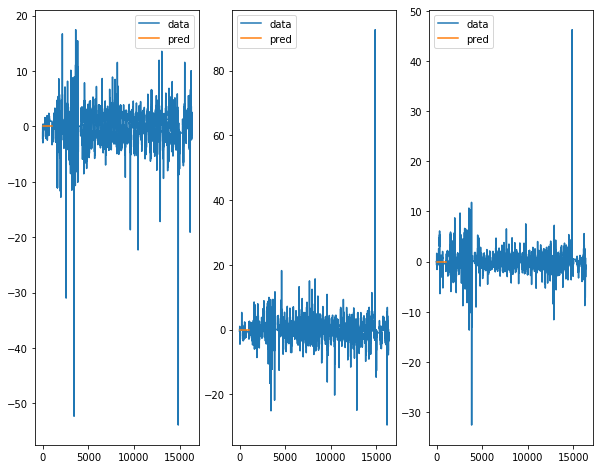

In [7]:
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.plot(y_data[:,k])
    plt.plot(y_pred[:,k])
    plt.legend(['data','pred'])
#plt.legend(['x: pred', 'y: pred', 'z: pred', 'x: true', 'y: true', 'z: true'])
#for k in range(n_steps, n_train):
#    print(k-n_steps, k, imu_data[k-n_steps:k, 1])
#    xk = imu_data[k-n_steps:k,:].reshape(1,n_steps,n_imu_input)


In [10]:
print(np.max(y_pred))
print(np.min(y_pred))


0.0
0.0


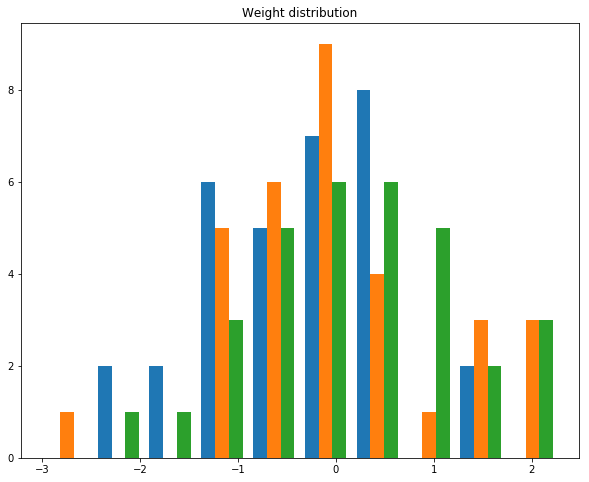

In [5]:
plt.title('Weight distribution')
plt.hist(w)
plt.show()

In [ ]:
# Just here as reference - squeezenet from hw3


import tensorflow as tf

NUM_CLASSES = 1000

def fire_module(x,inp,sp,e11p,e33p):
    with tf.variable_scope("fire"):
        with tf.variable_scope("squeeze"):
            W = tf.get_variable("weights",shape=[1,1,inp,sp])
            b = tf.get_variable("bias",shape=[sp])
            s = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")+b
            s = tf.nn.relu(s)
        with tf.variable_scope("e11"):
            W = tf.get_variable("weights",shape=[1,1,sp,e11p])
            b = tf.get_variable("bias",shape=[e11p])
            e11 = tf.nn.conv2d(s,W,[1,1,1,1],"VALID")+b
            e11 = tf.nn.relu(e11)
        with tf.variable_scope("e33"):
            W = tf.get_variable("weights",shape=[3,3,sp,e33p])
            b = tf.get_variable("bias",shape=[e33p])
            e33 = tf.nn.conv2d(s,W,[1,1,1,1],"SAME")+b
            e33 = tf.nn.relu(e33)
        return tf.concat([e11,e33],3)


class SqueezeNet(object):
    def extract_features(self, input=None, reuse=True):
        if input is None:
            input = self.image
        x = input
        layers = []
        with tf.variable_scope('features', reuse=reuse):
            with tf.variable_scope('layer0'):
                W = tf.get_variable("weights",shape=[3,3,3,64])
                b = tf.get_variable("bias",shape=[64])
                x = tf.nn.conv2d(x,W,[1,2,2,1],"VALID")
                x = tf.nn.bias_add(x,b)
                layers.append(x)
            with tf.variable_scope('layer1'):
                x = tf.nn.relu(x)
                layers.append(x)
            with tf.variable_scope('layer2'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer3'):
                x = fire_module(x,64,16,64,64)
                layers.append(x)
            with tf.variable_scope('layer4'):
                x = fire_module(x,128,16,64,64)
                layers.append(x)
            with tf.variable_scope('layer5'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer6'):
                x = fire_module(x,128,32,128,128)
                layers.append(x)
            with tf.variable_scope('layer7'):
                x = fire_module(x,256,32,128,128)
                layers.append(x)
            with tf.variable_scope('layer8'):
                x = tf.nn.max_pool(x,[1,3,3,1],strides=[1,2,2,1],padding='VALID')
                layers.append(x)
            with tf.variable_scope('layer9'):
                x = fire_module(x,256,48,192,192)
                layers.append(x)
            with tf.variable_scope('layer10'):
                x = fire_module(x,384,48,192,192)
                layers.append(x)
            with tf.variable_scope('layer11'):
                x = fire_module(x,384,64,256,256)
                layers.append(x)
            with tf.variable_scope('layer12'):
                x = fire_module(x,512,64,256,256)
                layers.append(x)
        return layers

    def __init__(self, save_path=None, sess=None):
        """Create a SqueezeNet model.
        Inputs:
        - save_path: path to TensorFlow checkpoint
        - sess: TensorFlow session
        """
        self.image = tf.placeholder('float',shape=[None,None,None,3],name='input_image')
        self.labels = tf.placeholder('int32', shape=[None], name='labels')
        self.layers = []
        x = self.image
        self.layers = self.extract_features(x, reuse=False)
        self.features = self.layers[-1]
        with tf.variable_scope('classifier'):
            with tf.variable_scope('layer0'):
                x = self.features
                self.layers.append(x)
            with tf.variable_scope('layer1'):
                W = tf.get_variable("weights",shape=[1,1,512,1000])
                b = tf.get_variable("bias",shape=[1000])
                x = tf.nn.conv2d(x,W,[1,1,1,1],"VALID")
                x = tf.nn.bias_add(x,b)
                self.layers.append(x)
            with tf.variable_scope('layer2'):
                x = tf.nn.relu(x)
                self.layers.append(x)
            with tf.variable_scope('layer3'):
                x = tf.nn.avg_pool(x,[1,13,13,1],strides=[1,13,13,1],padding='VALID')
                self.layers.append(x)
        self.classifier = tf.reshape(x,[-1, NUM_CLASSES])

        if save_path is not None:
            saver = tf.train.Saver()
#            saver = tf.train.import_meta_graph(save_path*'.meta')
            saver.restore(sess, save_path)
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.labels, NUM_CLASSES), logits=self.classifier))